# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
# Rows sorted by LAB L-value : 50, 20, 70
# Columns sorted by color : Rust, Turquoise, Sand, Indigo, Teal, Spring, Flesh, Magenta, Gray
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb','#777777'],
          ['#4C1C13','#073824','#2E186E','#575122','#065057','#164F14','#000000','#000000','#4D4D4D'],
          ['#FF745A','#0BD480','#9A7DF0','#FFF59C','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#ABABAB']]

plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "Georgia"
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 100

In [2]:
# Import custom libraries
import dlqr
import dynamics as dyn

In [3]:
# Simplify plots
def muteAxes(ax,xrange,yrange):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    ax.xaxis.set_ticks(xrange)
    ax.yaxis.set_ticks(yrange)

    ax.tick_params(direction='in')
    for xb in xrange:
        for yb in yrange:
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

# Define the Dynamics to be used
The dynamics functions are accessed through an extension of the dynamics abstract base class (DynamicsABC) that provides handles to the flow and its (partial) derivatives.

In [4]:
# Double integrator dynamics
class InvertedPendulum(dyn.DynamicsABC):

    """
    Encodes double integrator dynamics

    Operates on a two-dimensional state space (z) with numbered states encoding:

      1. Angular position (w)
      2. Angular velocity (v)

    with the form:

    dw/dt = v
    dv/dt = u_0 + 1*sin(w)
    """

    def f(self,state,control):
        """Dynamic drift function of state over time

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            derivative (np.array): the time derivative of state over time according to these dynamics
        """
        Az = np.array([state[1],1*np.sin(state[0])])
        Bu = np.array([0,control[0]])
        derivative = Az + Bu
        return(derivative)

    def deriv_x(self,state,control):
        """Derivative of dynamics with respect to state

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            A (np.array): partial derivative of dynamics with respect to state
        """
        A = np.zeros((2,2))
        A[0,1] = 1
        A[1,0] = 1*np.cos(state[0])
        return(A)

    def deriv_u(self,state,control):
        """Derivative of dynamics with respect to control

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            B (np.array): partial derivative of dynamics with respect to state
        """
        B = np.array([[0],[1]])
        return(B)

    def __init__(self):
        super(InvertedPendulum,self).__init__(2,1)

In [5]:
vehicle = InvertedPendulum()
timestep_length = 0.01

## Load the Barriers and test them

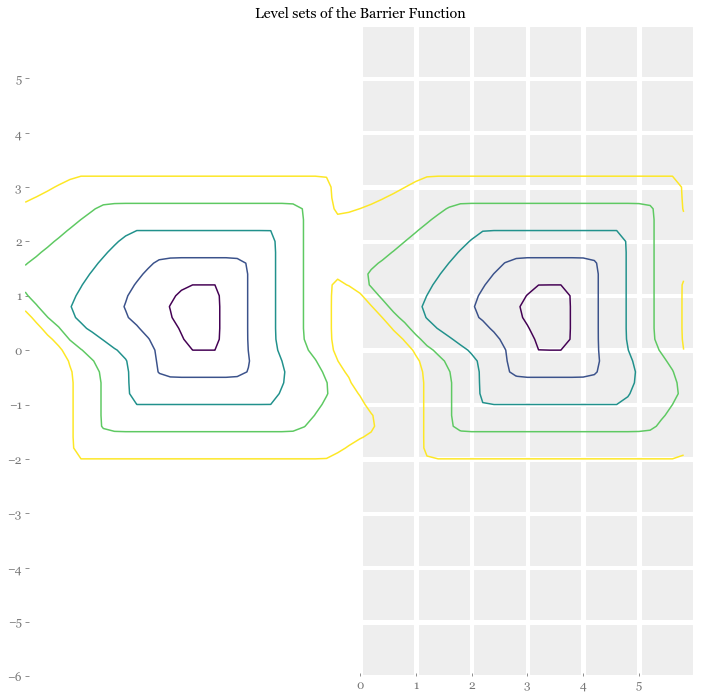

In [8]:
# Load the Safe Sets
import level_sets
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsStill_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum7Tenths_reachset.json")
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum4Ninths_reachset.json")

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(0,6),range(-6,6))

# Plot the safe set
delta = 0.2
x = np.arange(-6.0, 6.0, delta)
y = np.arange(-6.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([safeLevel.value([ex,ey]) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
CS = plt.contour(X, Y, Z, [0,0.5,1,1.5,2])

# Plot the gradient of the levels (the direction the controller will choose to go)
#u = np.array([safeLevel.gradient([ex,ey])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
#U = u.reshape(X.shape)
#v = np.array([safeLevel.gradient([ex,ey])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
#V = v.reshape(X.shape)
#plt.quiver(X,Y, U,V)

plt.title('Level sets of the Barrier Function')
plt.show()

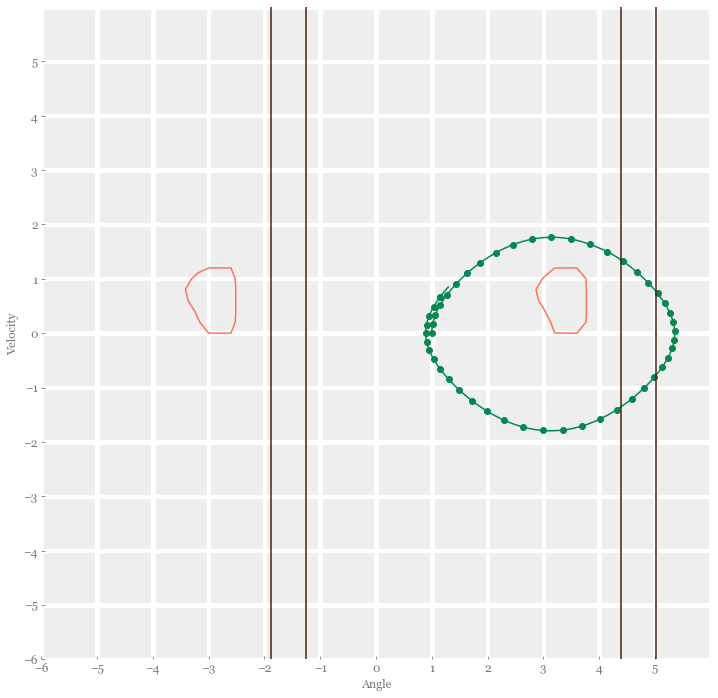

In [9]:
# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

# Test the safe set with controls that drive straight into the obstacle
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Forward simulate the dynamics with zero control
N = 1000
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))
states_init[:,0] = np.array([1,0])
for i in np.arange(0,N):
    control_init[:,i] = np.zeros((safe_vehicle.dimU,))
    states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

# Plot the safe set intervention behavior on a mindless controller
CS = plt.contour(X, Y, Z, [0], colors = [colors[2][0]])
plt.xlabel("Angle")
plt.ylabel("Velocity")

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

obsAngTick = 7
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

In [10]:
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)

## Set the Agent's goals

In [11]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(vehicle.dimU,np.diag([0.05]),np.zeros((vehicle.dimU,1)),0))

Qprox = np.diag([1,1])
goal_state = np.array([0,0])
terminalCost = of.TerminalCost(qof.QuadraticStateCost(
        dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        ) * 80)

Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

In [12]:
import ilqr

mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                            timestep_length,
                                                                            safe_vehicle,
                                                                            Agent_objective,
                                                                            terminal_cost = terminalCost * (1/timestep_length),
                                                                            neverRetreat=True,ITER_NUM=15)

Initialization's cost is  191.6809987495657
1 5.786534607963907
2 4.2869784463831415
3 2.2449940547600638
4 0.033692627819445604
5 0.01300211837047564
6 0.012275146874390805
7 0.0122345296144286
8 0.011925061708835833
9 0.011806934582385395
10 0.011623554599020616
11 0.01151366339704848
12 0.011385781145921795
13 0.011298404709699823
14 0.011203210022696341


<function matplotlib.pyplot.show(close=None, block=None)>

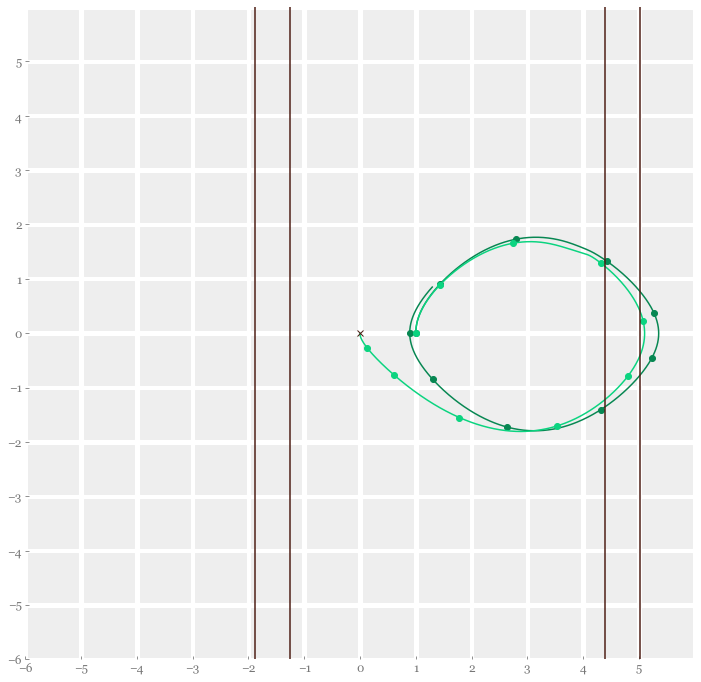

In [13]:
# Plot the resultant trajectories

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)
# Plot the initialization
plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,dotTimes],
         states_init[1,dotTimes],
         'ro',color=colors[0][1])

# Plot the iterative LQR optimized trajectory
plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,dotTimes],
         mintervener_method_states[1,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

plt.show

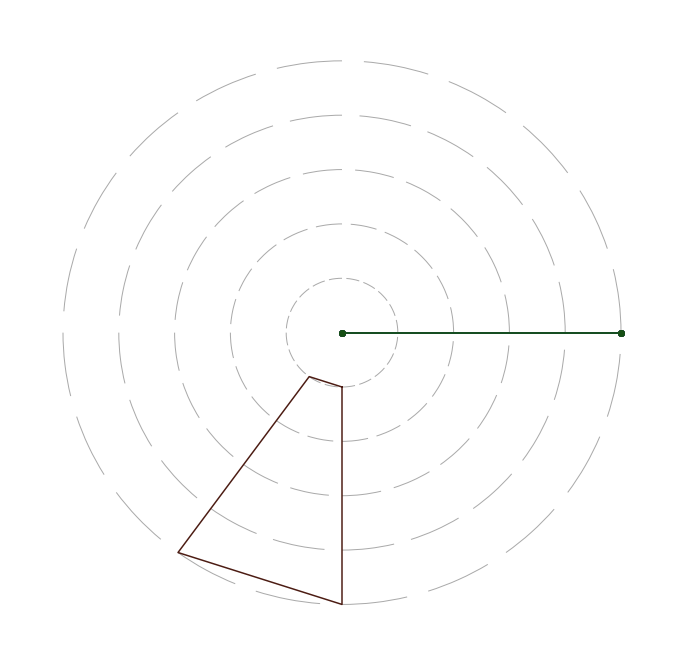

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(direction='in')
# Set incremental tilings
angle_grid_spacing = 0.05
for rb in [1,2,3,4,5]:
    for ab in np.arange(0,1,angle_grid_spacing):
        arc = mplt.patches.Arc((0,0),2*rb,2*rb,
                                color='#AAAAAA',
                                theta1 = 360*ab,
                                theta2 = 360*(ab+0.75*angle_grid_spacing))
        ax.add_patch(arc)
# Draw the obstacle
#"""
ax.plot([1*np.sin(angle1),1*np.sin(angle2),5*np.sin(angle2),5*np.sin(angle1),1*np.sin(angle1)],
        [1*np.cos(angle1),1*np.cos(angle2),5*np.cos(angle2),5*np.cos(angle1),1*np.cos(angle1)],
        color=colors[1][0])
#"""
#ax.xaxis.label.set_color('#777777')
#ax.tick_params(axis='x', colors='#777777')
#ax.yaxis.label.set_color('#777777')
#ax.tick_params(axis='y', colors='#777777')

lines = []
for ii in range(0,6):
    line, = ax.plot([0,5], [0,0], 'o-', color=colors[1][ii])
    lines.append(line)

In [31]:
# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data([], [])
    return (lines)

In [32]:
# animation function. This is called sequentially
length = 5
def animate(i):
    for ii in range(0,6):
        trace = OptimizedTraces[ii]
        angle = trace[0,i]
        speed = trace[1,i]
        x = [0,length * np.sin(angle)]
        y = [0,length * np.cos(angle)]
        lines[ii].set_data(x, y)
    return (lines)

In [33]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,
                               animate, init_func=init,
                               frames=1000,
                               interval=10, blit=True)
anim

In [34]:
writervideo = animation.FFMpegWriter(fps=60) 
anim.save("export/pendulumAgent_NoPeSpeedFiveTenthsObstacle.mp4", writer=writervideo)

In [17]:
import csv
with open('export/pendulumAgent_NoObstacle.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(mintervener_method_states[0,:])
    writer.writerow(mintervener_method_states[1,:])

# Batch Production
Generate some variance with a fixed constraint set for regressing upon.

In [14]:
# Plot the resultant trajectories
ys = [-10.0,-10.0, 10.0, 10.0,-10.0]

In [35]:
startingStates = [np.random.rand(2,) for ii in range(101)]
endingGoals = [np.random.rand(2,) for ii in range(101)]
for ii in range(101):
    while safeLevel.value(startingStates[ii]) < 0:
            startingStates[ii] = np.random.rand(2,)
    while safeLevel.value(endingGoals[ii]) < 0:
            endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2

In [19]:
for ii in [1,4,9]:
    startingStates[ii] = np.random.rand(2,)
    endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    print(startingStates[ii])
    print(endingGoals[ii])

[-0.85988307 -0.16661174]
[-1.81643102 -1.40251095]
[ 0.8219611  -0.43856732]
[-2.42643768 -1.13386402]


Initialization's cost is  219.21107816369042
1 62.837385853452936
2 27.29846443178271
3 4.463222441181944
4 0.2589092537918045
5 0.14083317629748057
6 0.022793374678574056
7 0.020175636152594566
8 0.01959976578065565
9 0.0193964314782956
10 0.019313499823274034
Initialization's cost is  12100.309726311443
1 480.9769446012613
2 260.99139595612576
3 191.97280368165383
4 77.44248416591859
5 71.69257733346396
6 5.883619496908869
7 1.3977752172951674
8 1.3630990989508776
9 1.3627923251160783
10 1.3383719596644224
Initialization's cost is  74.80794495658358
1 49.03564997395039
2 48.403918806401855
3 43.361500792652826
4 42.214879612268724
5 40.8990834663268
6 38.733480480174535
7 37.54242255919452
8 37.54242255919452
9 37.54242255919452
10 37.54242255919452
Initialization's cost is  12828.254928828996
1 874.2764200733277
2 310.5734407055288
3 93.6784437049432
4 62.8135104196372
5 35.32043205665528
6 30.708787499944343
7 24.81397697794228
8 23.38110729519953
9 20.274587185713987
10 19.6517691

5 1.7795184700610986
6 1.2198039191586276
7 0.6683761791407282
8 0.6501302520442316
9 0.6467642905829599
10 0.6452679011816745
Initialization's cost is  222.4242918392943
1 108.06181687922977
2 15.135155847649177
3 3.527130818931237
4 1.8808726282760315
5 0.6770325548729261
6 0.5966292077612689
7 0.5318856047199265
8 0.5273792656653901
9 0.5230199030457049
10 0.5219703306841637
Initialization's cost is  427.3553572519555
1 137.86137646759187
2 21.60323008738278
3 6.502286295362271
4 3.5708879417026336
5 2.945692632069959
6 0.38577728783851284
7 0.38019987377110875
8 0.3764899141293554
9 0.26933461028024935
10 0.26104877182579306
Initialization's cost is  2392.655858167262
1 1158.6485823438877
2 749.5785608684328
3 234.6996559479828
4 4.305972741141655
5 1.1827183920029851
6 0.9263371035745623
7 0.897176185459297
8 0.8958001950205181
9 0.8880420685304509
10 0.8834558221459657
Initialization's cost is  27037.72546604854
1 25632.34472015314
2 3387.91292478264
3 157.24351781887043
4 115.23

1 1659.3738307952306
2 1046.4552021242519
3 754.897341375091
4 262.40835191797777
5 121.09792421826626
6 52.7605288146112
7 26.392484644053226
8 19.299784196003607
9 16.64964557690573
10 13.362753597849496
Initialization's cost is  1139.9492550232733
1 772.6918016596807
2 693.0235660299497
3 632.6928723019172
4 523.4450314075815
5 523.4450314075815
6 523.4450314075815
7 523.4450314075815
8 523.4450314075815
9 523.4450314075815
10 523.4450314075815
Initialization's cost is  17132.2747976292
1 16249.492372356104
2 312.76735413365475
3 195.1621186772298
4 161.77325174019202
5 153.45029498185593
6 153.45029498185593
7 153.45029498185593
8 153.45029498185593
9 153.45029498185593
10 153.45029498185593
Initialization's cost is  111.4892270144828
1 35.95194062914296
2 7.912103336258921
3 2.353018153791131
4 0.6514262914955635
5 0.23392736590722532
6 0.11304173988584994
7 0.08294877597600822
8 0.07371132852479112
9 0.0716288077643229
10 0.07071229413120421
Initialization's cost is  415.70390930

7 0.008122396797601263
8 0.008097753301513496
9 0.008053637675406311
10 0.00802987704922538
Initialization's cost is  8878.637585030841
1 8351.821049059698
2 990.4765858076671
3 503.4816777366442
4 126.26665945583467
5 114.03777232901247
6 108.06488405186623
7 105.82979879230885
8 105.1059724409346
9 104.90536463409329
10 104.61769480338005
Initialization's cost is  45091.91161060254
1 2433.0901951064902
2 2432.6619735210747
3 2432.2325691180527
4 2431.801863242112
5 2431.3697303765675
6 2430.936037656734
7 2430.500644175814
8 2430.0633999997362
9 2429.6241463739116
10 2429.182714190353


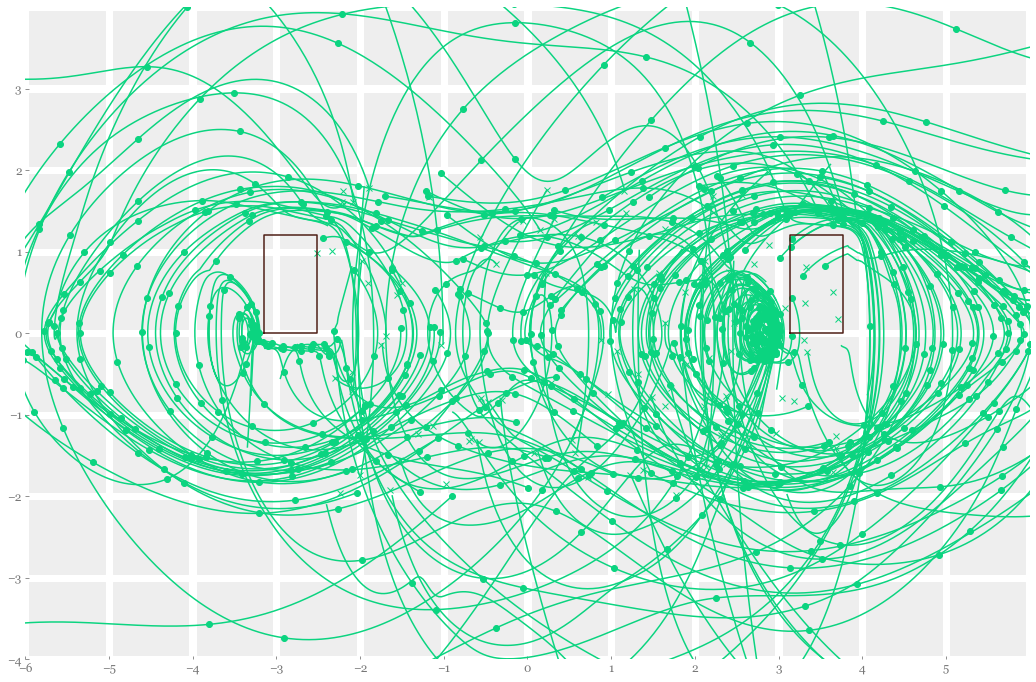

In [24]:
# Vary by randomizing start and end states

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
#safe_vehicle = vehicle
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[18,12])
plt.axis([-6,6,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-4,4))

dotTimes = np.arange(0,N,100)

OptimizedTraces = []

# Repeat optimization for multiple starting states
for ii in range(101):
    # Forward simulate the dynamics with zero control
    startingState = np.copy(startingStates[ii])
    states_init[:,0] = startingState
    for i in np.arange(0,N):
        control_init[:,i] = np.zeros((safe_vehicle.dimU,))
        states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

    # Optimize the trajectory
    Qprox = np.diag([1,1])
    goal_state = np.copy(endingGoals[ii])
    #goal_state[1] = 0
    terminalCost = of.TerminalCost(qof.QuadraticStateCost(
            dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                               -2*Qprox*np.matrix(goal_state).T,
                               np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
            ) * 80)
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=11)
    
    # Plot the iterative LQR optimized trajectory
    #thiscolor = colors[0][ii%9]
    thiscolor = colors[2][1]
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=thiscolor)
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=thiscolor)
    plt.plot(goal_state[0],goal_state[1],'x',color=thiscolor)
    OptimizedTraces.append(mintervener_method_states)

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_LownopeVObstacleTaxi'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1+2*np.pi,angle2+2*np.pi,angle2+2*np.pi,angle1+2*np.pi,angle1+2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show
plt.savefig("LownopeVObstacleTaxi.pdf")
# 0:Rust, 1:Turquoise, 2:Sand, 3:Indigo, 4:Teal, 5:Spring, 6:Flesh, 7:Magenta, 8:Gray

In [31]:
with open('export/pendulumAgent_startEnds_LownopeVObstacleTaxi'+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(range(0,100))
    writer.writerow([start[0] for start in startingStates])
    writer.writerow([start[1] for start in startingStates])
    writer.writerow([goal[0] for goal in endingGoals])
    writer.writerow([goal[1] for goal in endingGoals])

Initial cost is  [[178.85080649]]
Initialization's cost is  178.85080648570275
1 168.66979543671363
2 4.3653591265399045
3 0.6200990589783952
Initial cost is  [[13117.51483836]]
Initial cost is  [[199898.97713031]]
Initial cost is  [[2818.89968407]]
Initialization's cost is  2818.899684067443
1 1854.725541333636
2 1520.9435772068844
3 1402.7774722775168
Initial cost is  [[137198.24169811]]
Initial cost is  [[949.76754248]]
Initialization's cost is  949.7675424817851
1 919.029291995899
2 4.394955064838825
3 0.07144831808054786
Initial cost is  [[44853.67513755]]
Initial cost is  [[210617.95532603]]
Initial cost is  [[17215.96349563]]
Initial cost is  [[145851.96232216]]
Initial cost is  [[129344.87404193]]
Initial cost is  [[196.66697549]]
Initialization's cost is  196.66697548805905
1 5.7771076406596915
2 2.8088501597613025
3 2.643461247876948
Initial cost is  [[170499.11064434]]
Initial cost is  [[2651.39925493]]
Initialization's cost is  2651.3992549336654
1 1574.7943717955945
2 1164

1 2325.1524148611666
2 17.135789166075654
3 0.22402898308001867
Initial cost is  [[15462.26564355]]
Initial cost is  [[167850.32404338]]
Initial cost is  [[48229.6222891]]
Initial cost is  [[48912.84946671]]
Initial cost is  [[268422.49291195]]
Initial cost is  [[2689.55662444]]
Initialization's cost is  2689.5566244440797
1 2213.5257954214003
2 2064.1302865960183
3 1820.7652604729774
Initial cost is  [[153030.34520892]]
Initial cost is  [[234824.62650311]]
Initial cost is  [[81.22397506]]
Initialization's cost is  81.2239750612861
1 19.57303438283857
2 4.638384697791101
3 0.2012543306763592
Initial cost is  [[203794.64724085]]
Initial cost is  [[1839.99090733]]
Initialization's cost is  1839.990907332603
1 1185.681295002329
2 659.7082021386686
3 18.882252632813948
Initial cost is  [[2859.77360046]]
Initialization's cost is  2859.773600459722
1 2111.058044666603
2 1982.8139657104482
3 1727.1745263280734
Initial cost is  [[72021.93169853]]
Initial cost is  [[149317.75402288]]
Initial co

3 1.9800930807826742
Initial cost is  [[2821.38484764]]
Initialization's cost is  2821.384847638601
1 1907.4383918398858
2 1612.7925340185361
3 1457.8016357429467
Initial cost is  [[2826.58337411]]
Initialization's cost is  2826.5833741107367
1 2376.28880996172
2 27.753492383532482
3 0.3937154433583191
Initial cost is  [[80.95841824]]
Initialization's cost is  80.95841824186276
1 46.63046163356952
2 0.5586823583231924
3 0.0431368169308404
Initial cost is  [[78.12349402]]
Initialization's cost is  78.12349401784992
1 18.436099177010803
2 4.162989977557695
3 0.9372098026783079
Initial cost is  [[218.45289952]]
Initialization's cost is  218.45289952356816
1 64.45693505326857
2 8.051048370980627
3 0.189159228923249
Initial cost is  [[69.45848247]]
Initialization's cost is  69.4584824728983
1 13.295790865084784
2 2.6334278203029426
3 1.6751725493573777
Initial cost is  [[177.79384331]]
Initialization's cost is  177.79384330904995
1 71.56857676544502
2 5.7630400827620125
3 5.43996474206013
I

<function matplotlib.pyplot.show(close=None, block=None)>

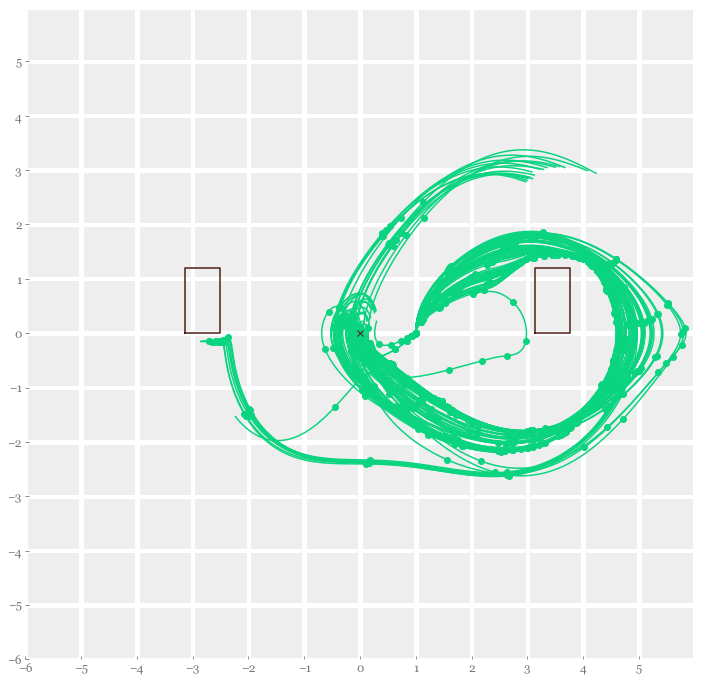

In [21]:
# Vary by randomizing initial control sequence

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
startingState = [1,0]
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)

# Repeat optimization for multiple starting states
for ii in range(1,100):
    cost = 999999
    while cost > 10000:
        # Forward simulate the dynamics with zero control
        states_init[:,0] = startingState
        cost = 0
        #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
        constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
        for i in np.arange(0,N):
            #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
            control_init[:,i] = constant_control
            states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
            cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
        cost = cost + terminalCost.f(states_init[:,N])
        print("Initial cost is ",cost)
        
    # Optimize the trajectory
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=4)
    
    # Plot the iterative LQR optimized trajectory
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=colors[2][1])

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_5TenthsNopeVObstacleTruncated'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show

In [25]:
endingGoals.shape

AttributeError: 'list' object has no attribute 'shape'